Example notebook showing how to work with a _Track_ observation from Green Bank's 20m telescope.

In [1]:
# Import the packages we will need.
import os
import linecache
import numpy as np
import pandas as pd
import astropy.units as u
import matplotlib.pyplot as plt

from specutils import Spectrum1D, SpectralRegion
from specutils.manipulation import extract_region
from specutils.fitting import fit_continuum, fit_generic_continuum
from astropy.modeling.polynomial import Polynomial1D
from astropy.modeling.fitting import LinearLSQFitter

Now we need to download our calibrated _Track_ data. From the GBO website for your observations, right click on the *Spectra* _Calibrated_ button and select _Copy Link Address_.

![Picture showing how to copy the link to download a calibrated track observation](example_track_data_download.png "Example Track Data Download")

Paste the copied url in the following code block and execute it to download your data to the current folder.

In [2]:
cal_data_url = "http://www.gb.nrao.edu/20m/peak/SDSS_07_135T1/Skynet_60165_sdss_07_135T1_100990_49922.A.spect.cal.txt"
os.system(f"wget {cal_data_url}")  

--2023-08-09 15:19:12--  http://www.gb.nrao.edu/20m/peak/SDSS_07_135T1/Skynet_60165_sdss_07_135T1_100990_49922.A.spect.cal.txt
Resolving www.gb.nrao.edu (www.gb.nrao.edu)... 192.33.116.7
Connecting to www.gb.nrao.edu (www.gb.nrao.edu)|192.33.116.7|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.gb.nrao.edu/20m/peak/SDSS_07_135T1/Skynet_60165_sdss_07_135T1_100990_49922.A.spect.cal.txt [following]
--2023-08-09 15:19:12--  https://www.gb.nrao.edu/20m/peak/SDSS_07_135T1/Skynet_60165_sdss_07_135T1_100990_49922.A.spect.cal.txt
Connecting to www.gb.nrao.edu (www.gb.nrao.edu)|192.33.116.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75557 (74K) [text/plain]
Saving to: ‘Skynet_60165_sdss_07_135T1_100990_49922.A.spect.cal.txt.2’

     0K .......... .......... .......... .......... .......... 67% 45.5M 0s
    50K .......... .......... ...                             100% 48.7M=0.002s

2023-08-09 15:19:12 (46.5 MB/s) - ‘Skynet_

0

Now we will open the downloaded data and put it in a `pandas` `DataFrame`.

In [3]:
# Select the filename from the full url.
fname = os.path.basename(cal_data_url)
# Read in line 68 of the file.
# This line has the column names.
header_line = linecache.getline(fname, 68)
# Remove the first # from the line and split it.
# We will use this as our column names when reading 
# the calibrated spectra.
col_names = header_line[1:].split()
print("These will be the column names:")
print(col_names)
df = pd.read_csv(fname, comment="#", delim_whitespace=True, names=col_names)

These will be the column names:
['Freq1(MHz)', 'XX1', 'YY1', 'Freq2(MHz)', 'XX2', 'YY2']


In [4]:
# Show the contents of the `pandas.DataFrame`.
df

,Freq1(MHz),XX1,YY1,Freq2(MHz),XX2,YY2
0,1672.03430,18.7531,26.7458,1422.03430,16.6295,18.3026
1,1672.01904,18.9278,26.8194,1422.01904,16.6871,18.3994
2,1672.00378,19.0108,26.9266,1422.00378,16.7771,18.5234
3,1671.98853,19.1060,27.0966,1421.98853,16.8558,18.6456
4,1671.97327,19.1936,27.3081,1421.97327,16.9582,18.7720
...,...,...,...,...,...,...
916,1658.05725,21.4883,26.8191,1408.05725,17.3609,16.2136
917,1658.04199,21.4008,26.6874,1408.04199,17.2237,16.1537
918,1658.02673,21.2445,26.5496,1408.02673,17.1520,16.1043
919,1658.01147,21.1492,26.5014,1408.01147,17.0623,16.0167


Now we will display the calibrated data using `matplotlib`. This should look identical to the figures shown in the GBO 20m data page where we got our data url from.

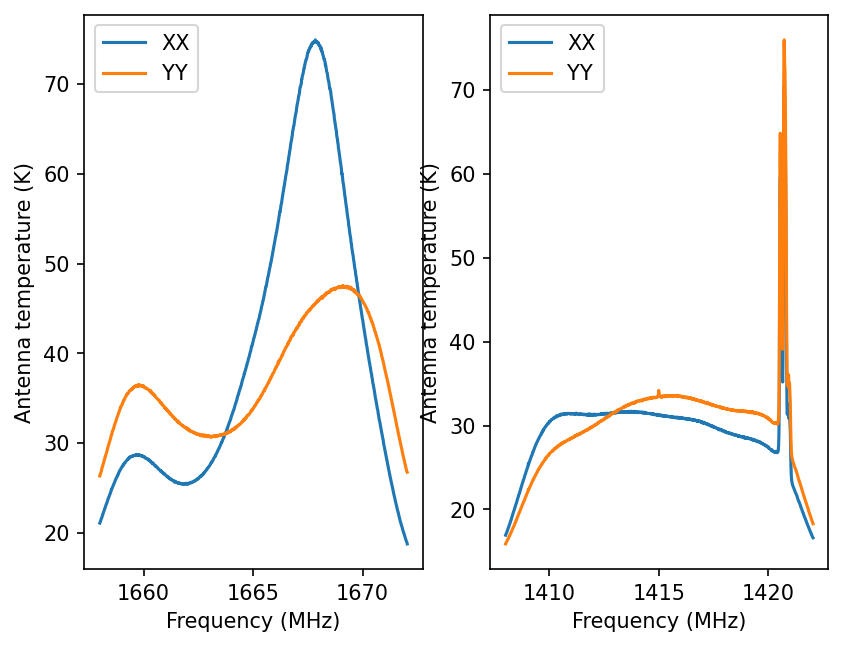

In [5]:
# Plot the data from both spectral windows.
plt.figure(dpi=150)
plt.subplot(121)
plt.plot(df["Freq1(MHz)"], df["XX1"], label="XX")
plt.plot(df["Freq1(MHz)"], df["YY1"], label="YY")
plt.legend()
plt.xlabel("Frequency (MHz)")
plt.ylabel("Antenna temperature (K)")
plt.subplot(122)
plt.plot(df["Freq2(MHz)"], df["XX2"], label="XX")
plt.plot(df["Freq2(MHz)"], df["YY2"], label="YY")
plt.legend()
plt.xlabel("Frequency (MHz)")
plt.ylabel("Antenna temperature (K)");

In this example we have two spectral windows. Spectral window 1 contains the 18cm OH lines at 1665 and 1667 MHz, spectral window 2 contains the 21cm line at 1420.4 MHz.

In this example we will focus on the 21cm line.

The next block will create a `specutils.Spectrum1D` object with the 21cm spectral window. For simplicity, we will also select a narrow range of frequencies around the 21cm line. Specifically the range between 1419 and 1422 MHz.

In [6]:
# Let's work with the spectral window that has the HI line in it.
freq2 = df["Freq2(MHz)"].to_numpy() * u.MHz
xx2 = df["XX2"].to_numpy() * u.K
spec_xx2 = Spectrum1D(spectral_axis=freq2, flux=xx2)
# Now, extract a smaller frequency range around the 21cm line.
region = SpectralRegion(1419*u.MHz, 1422*u.MHz)
sub_spec_xx2 = extract_region(spec_xx2, region)

Now we want to subtract the instrumental baseline. For this we will fit a polynomial of order 5 to the line free channels.

In [7]:
# Fit a polynomial to remove the baseline.
# We will ignore this frequency range, 
# because this is where our line of interest is.
sr = SpectralRegion(1420*u.MHz, 1421*u.MHz)
# We will use a polynomial of order 5.
model = Polynomial1D(degree=5)
# A linear fit should be ok in this case.
fitter = LinearLSQFitter(calc_uncertainties=True)
# Fit!
baseline_fit = fit_continuum(spectrum=sub_spec_xx2,
                             model=model,
                             fitter=fitter,
                             exclude_regions=sr)

 [astropy.modeling.fitting]


Now let's look at the results. We will plot the calibrated data and the best fit baseline, and then the baseline subtracted data.

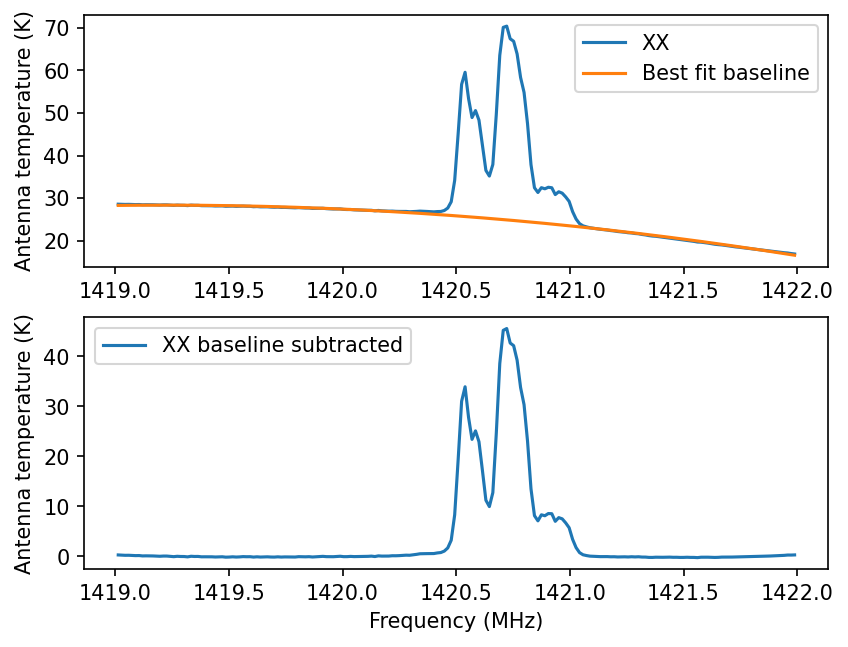

In [8]:
# Show the data and the baseline fit and 
# the baseline subtracted data.
x = sub_spec_xx2.spectral_axis
y = sub_spec_xx2.flux
yb = baseline_fit(sub_spec_xx2.spectral_axis)

plt.figure(dpi=150)
plt.subplot(211)
plt.plot(x, y, label="XX")
plt.plot(x, yb, label="Best fit baseline")
plt.legend()
plt.ylabel("Antenna temperature (K)");
plt.subplot(212)
plt.plot(x, y - yb, label="XX baseline subtracted")
plt.legend()
plt.xlabel("Frequency (MHz)")
plt.ylabel("Antenna temperature (K)");

Now we will write the baseline subtracted to a text file.

In [9]:
np.savetxt("baseline_subtracted_xx2.txt", np.c_[sub_spec_xx2.spectral_axis.to("MHz").value,
                                                (sub_spec_xx2.flux - baseline_fit(sub_spec_xx2.spectral_axis)).to("K").value])

If we wanted to resume our work with the recently written baseline subtracted spectrum we could do:

    spec1d = np.loadtxt("baseline_subtracted_xx2.txt")

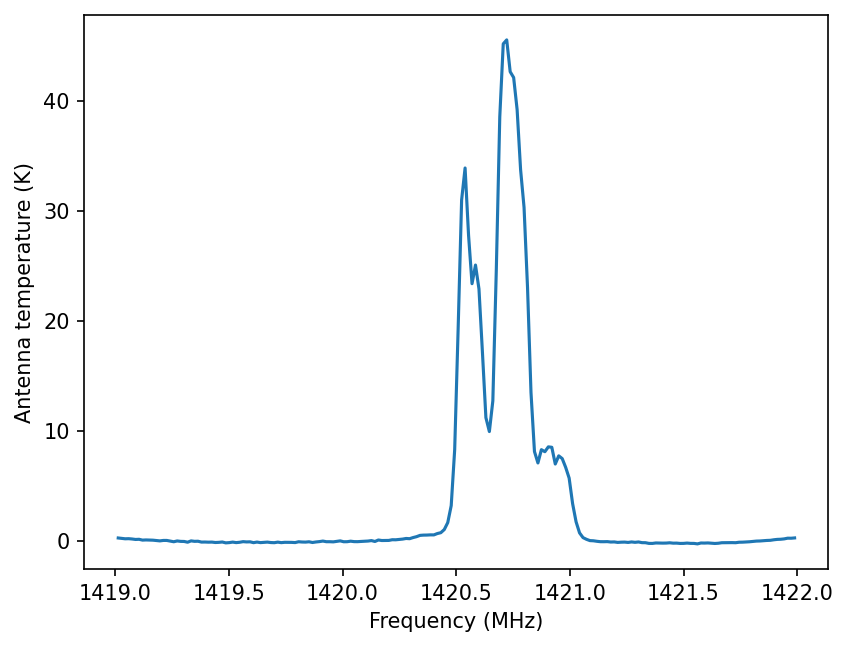

In [10]:
# Let's try it for fun.
spec1d = np.loadtxt("baseline_subtracted_xx2.txt")

plt.figure(dpi=150)
plt.plot(spec1d[:,0], spec1d[:,1])
plt.xlabel("Frequency (MHz)")
plt.ylabel("Antenna temperature (K)");